In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
# Load the dataset
dataset = pd.read_csv('data/train.csv')

In [3]:
dataset.tail()

,id,race,date,time,circuit,latitude,longitude,altitude,driver,carNumber,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
29995,29996,Azerbaijan Grand Prix,2021-06-06,12:00:00,Baku City Circuit,40.3725,49.85330,-7,"Alonso, Fernando",14,Alpine F1 Team,7.448925,5.303571,39,11,0,2,0.0,106314
29996,29997,Chinese Grand Prix,2016-04-17,06:00:00,Shanghai International Circuit,31.3389,121.22000,5,"Rosberg, Nico",6,Mercedes,6.766990,2.199262,53,1,0,2,0.0,100814
29997,29998,European Grand Prix,2002-06-23,NaN,Nürburgring,50.3356,6.94750,578,"Trulli, Jarno",14,Renault,11.580000,5.199507,40,6,0,0,0.0,95675
29998,29999,United States Grand Prix,2014-11-02,20:00:00,Circuit of the Americas,30.1328,-97.64110,161,"Rosberg, Nico",6,Mercedes,6.766990,2.199262,13,1,0,0,0.0,104406
29999,30000,Italian Grand Prix,1997-09-07,NaN,Autodromo Nazionale di Monza,45.6156,9.28111,162,"Schumacher, Michael",5,Ferrari,4.325879,2.833984,16,7,0,0,0.0,87347


In [4]:
dataset.drop(['id', 'race', 'carNumber'], axis=1, inplace=True)
dataset['time'].fillna('NaN', inplace=True)

#### Separating the features and the target

In [5]:
# Separate the features and the target
X = dataset.drop('lapTime_ms', axis=1)
y = dataset['lapTime_ms']

#### Splitting the dataset into train and test data

In [6]:
# Split the dataset into training (80%) and testing (20%) sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop("lapTime_ms")
y_test = X_test.pop("lapTime_ms")

#### Defining an initial model

In [7]:
# Define the model
init_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    loss_function='RMSE',
    random_seed=42,
    cat_features=['date', 'time', 'circuit', 'driver', 'constructor', 'pitStop']
)

# Train the model
init_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    early_stopping_rounds=50
)

# Save the model
init_model.save_model('models/init_model.cbm')

0:	learn: 61502.2932586	test: 66474.6249575	best: 66474.6249575 (0)	total: 216ms	remaining: 3m 35s
100:	learn: 13255.8864192	test: 19319.8242333	best: 19319.8242333 (100)	total: 5.75s	remaining: 51.2s
200:	learn: 6362.9451158	test: 14753.8650140	best: 14753.8650140 (200)	total: 11.4s	remaining: 45.4s
300:	learn: 5101.6632222	test: 14205.6882013	best: 14205.6882013 (300)	total: 17.2s	remaining: 40s
400:	learn: 4551.1862652	test: 14009.4656818	best: 14009.4656818 (400)	total: 23s	remaining: 34.3s
500:	learn: 4223.9731617	test: 13925.6248470	best: 13925.6248470 (500)	total: 28.7s	remaining: 28.6s
600:	learn: 3961.3730954	test: 13891.7957321	best: 13891.7773718 (599)	total: 34.5s	remaining: 22.9s
700:	learn: 3761.1889909	test: 13874.8755644	best: 13874.3902854 (699)	total: 40.3s	remaining: 17.2s
800:	learn: 3576.1852271	test: 13847.9993870	best: 13847.2650493 (795)	total: 46.8s	remaining: 11.6s
900:	learn: 3408.2373954	test: 13829.8867077	best: 13829.6954145 (898)	total: 52.6s	remaining: 5

#### Finding the optimal parameters for the model

In [8]:
# Define the parameter grid
param_grid = {
    'iterations': [500, 1000, 1500],        # number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # step size of each iteration
    'depth': [6, 8, 10]                     # depth of each tree
}

# Create the model
model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    cat_features=['date', 'time', 'circuit', 'driver', 'constructor', 'pitStop']
)

# Find the optimal parameters
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42
)

random_search.fit(X, y)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
0:	learn: 64449.6459549	total: 26.4ms	remaining: 39.6s
1:	learn: 63133.9249463	total: 54.8ms	remaining: 41.1s
2:	learn: 61418.4514300	total: 81.2ms	remaining: 40.5s
3:	learn: 60333.8679381	total: 106ms	remaining: 39.7s
4:	learn: 59643.4520436	total: 132ms	remaining: 39.4s
5:	learn: 59028.2871138	total: 157ms	remaining: 39.1s
6:	learn: 58452.0000741	total: 183ms	remaining: 39s
7:	learn: 58066.9536280	total: 210ms	remaining: 39.2s
8:	learn: 57539.0421726	total: 237ms	remaining: 39.2s
9:	learn: 56986.5534325	total: 263ms	remaining: 39.1s
10:	learn: 56699.3904557	total: 288ms	remaining: 39s
11:	learn: 56349.5889428	total: 315ms	remaining: 39s
12:	learn: 55859.4388899	total: 339ms	remaining: 38.8s
13:	learn: 55599.7065055	total: 366ms	remaining: 38.8s
14:	learn: 55292.1833183	total: 391ms	remaining: 38.7s
15:	learn: 54935.2430578	total: 418ms	remaining: 38.7s
16:	learn: 54670.4299246	total: 444ms	remaining: 38.8s
17:	learn: 54519.9

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000021A000084D0>,
                   n_iter=5,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [500, 1000, 1500],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

#### Defining a new model with the optimal parameters found

In [9]:
opt_model = random_search.best_estimator_
opt_model.save_model('models/opt_model.cbm')
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'learning_rate': 0.05, 'iterations': 1000, 'depth': 8}


#### Loading the models

In [ ]:
# Initial model
init_model = CatBoostRegressor()
init_model.load_model('models/init_model.cbm')

# Optimized model
opt_model = CatBoostRegressor()
opt_model.load_model('models/opt_model.cbm')

#### Comparing predictions obtained for the train dataset with both models

In [11]:
train_pred_init = init_model.predict(X_train)

train_pred_opt = opt_model.predict(X_train)

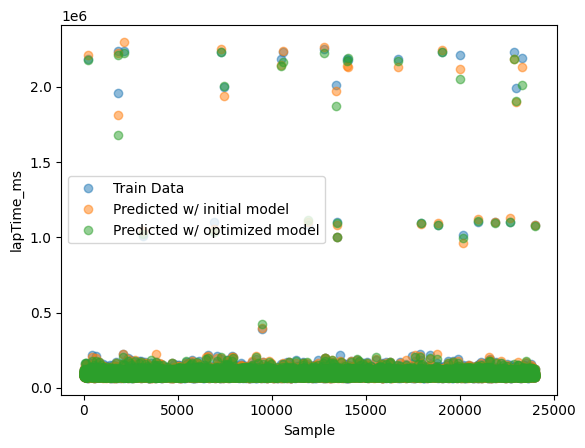

RMSE on train data w/ initial model:  4205.978212222453
RMSE on train data w/ optimized model:  5615.948203714428
Accuracy on train data w/ initial model:  0.995506795485806
Accuracy on train data w/ optimized model:  0.9919893393114323


In [12]:
plt.plot(y_train.to_numpy(), 'o', label='Train Data', alpha=0.5)
plt.plot(train_pred_init, 'o', label='Predicted w/ initial model', alpha=0.5)
plt.plot(train_pred_opt, 'o', label='Predicted w/ optimized model', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('lapTime_ms')
plt.legend()
plt.show()

print("RMSE on train data w/ initial model: ", np.sqrt(np.mean((train_pred_init - y_train) ** 2)))
print("RMSE on train data w/ optimized model: ", np.sqrt(np.mean((train_pred_opt - y_train) ** 2)))

print("Accuracy on train data w/ initial model: ", init_model.score(X_train, y_train))
print("Accuracy on train data w/ optimized model: ", opt_model.score(X_train, y_train))

#### Comparing predictions obtained for the test dataset with both models

In [13]:
test_pred_init = init_model.predict(X_test)
test_pred_opt = opt_model.predict(X_test)

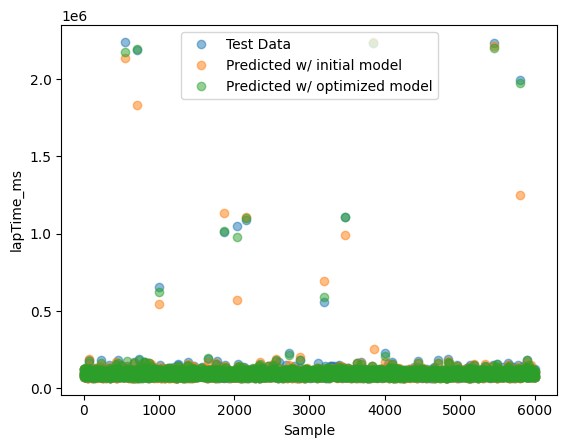

RMSE on test data w/ initial model:  13824.37185987869
RMSE on test data 1 w/ optimized model:  4812.370542361958
Accuracy on test data w/ initial model:  0.9582190928757643
Accuracy on test data w/ optimized model:  0.9949370321490093


In [14]:
plt.plot(y_test.to_numpy(), 'o', label='Test Data', alpha=0.5)
plt.plot(test_pred_init, 'o', label='Predicted w/ initial model', alpha=0.5)
plt.plot(test_pred_opt, 'o', label='Predicted w/ optimized model', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('lapTime_ms')
plt.legend()
plt.show()

print("RMSE on test data w/ initial model: ", np.sqrt(np.mean((test_pred_init - y_test) ** 2)))
print("RMSE on test data 1 w/ optimized model: ", np.sqrt(np.mean((test_pred_opt - y_test) ** 2)))

print("Accuracy on test data w/ initial model: ", init_model.score(X_test, y_test))
print("Accuracy on test data w/ optimized model: ", opt_model.score(X_test, y_test))

#### Loading an evaluation (unseen) dataset

In [15]:
# Load the evaluation dataset
dataset_eval = pd.read_csv('data/test.csv')

In [16]:
df_eval = dataset_eval.drop(['id', 'race', 'carNumber'], axis=1)
df_eval['time'].fillna('NaN', inplace=True)

#### Obtaining predictions for the evaluation dataset with both models

In [17]:
eval_pred_init = init_model.predict(df_eval)
eval_pred_opt = opt_model.predict(df_eval)

In [18]:
df_results_init = pd.DataFrame(dataset_eval['id'], columns=['id'])
df_results_init['lapTime_ms'] = eval_pred_init

df_results_opt = pd.DataFrame(dataset_eval['id'], columns=['id'])
df_results_opt['lapTime_ms'] = eval_pred_opt

In [19]:
# Save the results obtained with both models
df_results_init.to_csv('results/results_init.csv', index=False)
df_results_opt.to_csv('results/results_opt.csv', index=False)